# Reading Cloud Optimized Datasets at PO.DAAC

#### *Author: Mike Gangl, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

### ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4

This tutorial will showcase basid reading of a virtual collection over HTTP. This allows a user inside or outside of a cloud environment to access only the required pieces of data for their analysis. For example, identifying a time range and/or a spatial bounding box will limit the retrieval to only those pieces of data.

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

#### Prerequisite knowledge

* Familiarity with the `earthaccess` and `Xarray` packages. Familiarity with directly accessing NASA Earthdata in the cloud. 

* The Cookbook notebook on [Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) is handy for those new to parallel computating.


## Import Packages
#### ***Note Zarr Version***
***Zarr version 2 is needed for the current implementation of this notebook, due to (as of February 2025) Zarr version 3 not accepting `FSMap` objects.***

We ran this notebook in a Python 3.12 environment. The minimal working environment we used to run this notebook was:
```
zarr==2.18.4
fastparquet==2024.5.0
xarray==2025.1.2
earthaccess==0.11.0
fsspec==2024.10.0
dask==2024.5.2 ("dask[complete]"==2024.5.2 if using pip)
h5netcdf==1.3.0
matplotlib==3.9.2
jupyterlab
jupyter-server-proxy
virtualizarr==1.3.0
kerchunk==0.2.7
```

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
from virtualizarr import open_virtual_dataset

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import boto3
import numpy as np


In [2]:
# The shortname of the collection you'd like to explore
collection_shortname = "ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4"

# No need to modify this, it will be filled in with the shortname information above. This file is publicly accessible without EDL requirements as it is not _data_ itself. 
virtual_collection = f"https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/{collection_shortname}/{collection_shortname}_virtual.json"


## Other Setup

In [3]:
# xr.set_options( # display options for xarray objects
#     display_expand_attrs=False,
#     display_expand_coords=True,
#     display_expand_data=True,
# )

## 1. Get Data File https endpoints


In [4]:
# Get Earthdata creds
earthaccess.login()

In [5]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_fsspec_https_session() 

In [6]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.


In [7]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "https", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [8]:
%%time
# Use the above function open the virtual collection.
# Depending on your internet connection, it may take some time to download the file. Once downloaded,
# it is used to map to the actual data files within the PO.DAAC Archive.

data_example = opends_withref(virtual_collection, fs)
data_example

CPU times: user 1.28 s, sys: 377 ms, total: 1.66 s
Wall time: 7.9 s


<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) float64 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>

In [9]:
# At this point, we jhave downlaoded the virtual collection, but have not gone and retrieved any data yet. 
# Also useful to note, these reference objects don't take much memory:
print(sys.getsizeof(data_example), "bytes")

120 bytes


In [10]:
# Start up cluster and print some information about it:
import multiprocessing

# You can adjust these as you desire.
client = Client(n_workers=multiprocessing.cpu_count(), threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(934a5ff2, 'tcp://127.0.0.1:54167', workers=12, threads=12, memory=64.00 GiB)
View any work being done on the cluster here http://127.0.0.1:8787/status


In [11]:
salt = data_example.SALT
salt

<xarray.DataArray 'SALT' (time: 9497, Z: 50, latitude: 360, longitude: 720)> Size: 492GB
dask.array<open_dataset-SALT, shape=(9497, 50, 360, 720), dtype=float32, chunksize=(1, 25, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Z          (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-12-31T...

In [12]:
print(f"Time Range of Virtual Collection: {data_example.time.min()} - {data_example.time.max()}")

Time Range of Virtual Collection: <xarray.DataArray 'time' ()> Size: 8B
array('1992-01-01T18:00:00.000000000', dtype='datetime64[ns]') - <xarray.DataArray 'time' ()> Size: 8B
array('2017-12-31T06:00:00.000000000', dtype='datetime64[ns]')


In [13]:
# Choose a time of interest. 
dates = slice('2017-01-01', '2017-03-31')
salt.sel(time=dates)

<xarray.DataArray 'SALT' (time: 90, Z: 50, latitude: 360, longitude: 720)> Size: 5GB
dask.array<getitem, shape=(90, 50, 360, 720), dtype=float32, chunksize=(1, 25, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Z          (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 720B 2017-01-01T12:00:00 ... 2017-03-31T...

In [14]:
# Choose a region via lat/lon to explore
# Mediterranean Sea
lats = slice(32, 48)
lons = slice(-10, 40)

# Atlantic Ocean Area
# lats = slice(30, 45)
# lons = slice(315, 330)

#gulf of Mexico
#lats = slice(15, 35)
#lons = slice(255, 285)

# Limit the underlying data. We have still not "downlaoded" data yet.
med_salt = salt.sel(latitude=lats, longitude=lons, Z=-5, time=dates)
med_salt

<xarray.DataArray 'SALT' (time: 90, latitude: 32, longitude: 100)> Size: 1MB
dask.array<getitem, shape=(90, 32, 100), dtype=float32, chunksize=(1, 32, 80), chunktype=numpy.ndarray>
Coordinates:
    Z          float32 4B -5.0
  * latitude   (latitude) float32 128B 32.25 32.75 33.25 ... 46.75 47.25 47.75
  * longitude  (longitude) float32 400B -9.75 -9.25 -8.75 ... 38.75 39.25 39.75
  * time       (time) datetime64[ns] 720B 2017-01-01T12:00:00 ... 2017-03-31T...

In [15]:
%%time
# Here we will actually _force_ the data to be downloaded.
# We can do this by doing an explicit load() command or we could do a computation, like an average over lat/lon.
# Both of these operations would force us to download the chunks of data above to do the calculation.

med_salt.load()

CPU times: user 1.98 s, sys: 890 ms, total: 2.87 s
Wall time: 33.8 s


<xarray.DataArray 'SALT' (time: 90, latitude: 32, longitude: 100)> Size: 1MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.323177, 36.323177,       nan, ...,       nan,       nan,
               nan],
        [36.322407, 36.322407, 36.29235 , ...,       nan,       nan,
               nan],
        ...,
        [35.58217 , 35.58217 , 35.58096 , ...,       nan,       nan,
               nan],
        [35.56033 , 35.56033 , 35.560192, ...,       nan,       nan,
               nan],
        [35.53698 , 35.53698 , 35.536327, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.32474 , 36.32474 ,       nan, ...,       nan,       nan,
               nan],
        [36.3235  , 36.3235  , 36.293633, ...,       nan,       nan,
               nan],
...
        [35.568775, 35.568775, 35.56786 , ...,       nan,       nan,
               nan],
        [35.554363, 35.554363, 35.553394, ...,       nan,       nan,
               nan],
        [35.540695, 35.540695, 35.538826, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.31974 , 36.31974 ,       nan, ...,       nan,       nan,
               nan],
        [36.297146, 36.297146, 36.28647 , ...,       nan,       nan,
               nan],
        ...,
        [35.564484, 35.564484, 35.562435, ...,       nan,       nan,
               nan],
        [35.550476, 35.550476, 35.54765 , ...,       nan,       nan,
               nan],
        [35.537643, 35.537643, 35.533627, ...,       nan,       nan,
               nan]]], shape=(90, 32, 100), dtype=float32)
Coordinates:
    Z          float32 4B -5.0
  * latitude   (latitude) float32 128B 32.25 32.75 33.25 ... 46.75 47.25 47.75
  * longitude  (longitude) float32 400B -9.75 -9.25 -8.75 ... 38.75 39.25 39.75
  * time       (time) datetime64[ns] 720B 2017-01-01T12:00:00 ... 2017-03-31T...

## Results
The `%%time` allows us to see how long a particular cell took. On my machine, over wireless internet, it took me 1m 43s to access 2 months of the ECCO data for my region of interest. to download this data and analyze on your laptop, even for a small region, would be close to 530MB of data. Now that we have the data for our region locally, we can explore it:

(array([13024.,  2478.,  7512.,  4254.,  4182.,  5798., 12858., 16292.,
        20820., 21862.]),
 array([35.25403214, 35.657547  , 36.06105804, 36.46457291, 36.86808395,
        37.27159882, 37.67511368, 38.07862473, 38.48213959, 38.88565063,
        39.2891655 ]),
 <BarContainer object of 10 artists>)

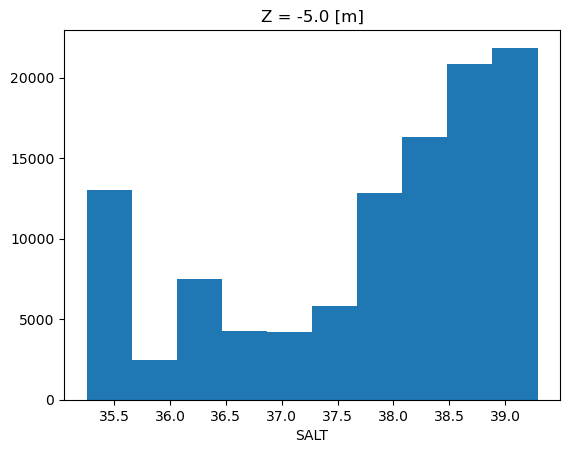

In [16]:
# With the data "laoded", we can do some basic computation on it:
med_salt.plot()

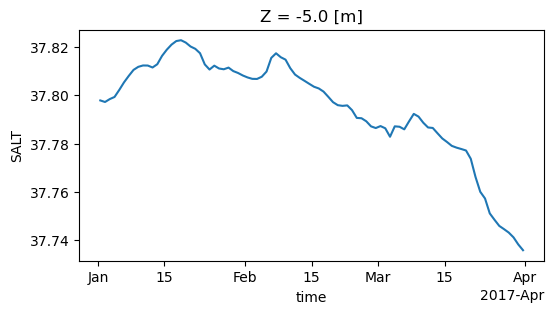

In [17]:
med_salt_mean = med_salt.mean(dim=["latitude","longitude"])
med_salt_mean.plot(aspect=2, size=3)


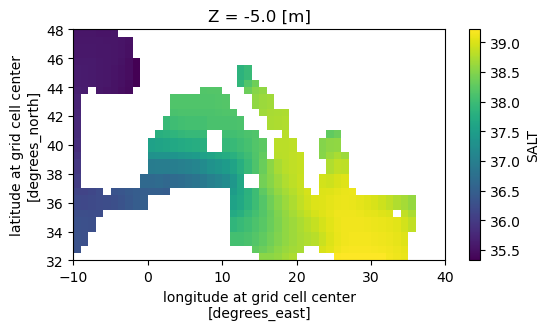

In [18]:
med_salt.mean(dim=["time"]).plot(aspect=2, size=3)